In [ ]:
# Run on google colab only
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/DRL-based-Recommendation'

import os
os.chdir(root_path)

In [1]:
from __future__ import print_function
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data
import matplotlib.pyplot as plt

from model import PMF
from evaluations import RMSE

In [2]:
# Input batch size for training
batch_size = 100000
# Number of maximum epoches to train
epoches = 60
# Enables CUDA training
enable_cuda = False
# Generate random seed
seed = 42
# Weight decay
weight_decay = 0.1
# Size of embedding features
embedding_feature_size = 100
# Train ratio
train_ratio = 0.8
# Val ratio
val_ratio = 0.1
# Learning rate
lr = 0.0001
# Momentum value
momentum = 0.9

In [3]:
# Load datasets
user = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
rest = pickle.load(open('dataset/item_id_to_num.pkl', 'rb'))
data = np.load('dataset/data.npy', allow_pickle=True)

# Normalize rewards to [-1, 1]
data[:, 0] = np.where(np.isin(data[:, 0], [1, 2]), -1, 
                      np.where(data[:, 0] == 3, 0, 1))
print(data)
# Shuffle data
np.random.shuffle(data)

# Split data
train_data = data[:int(train_ratio*data.shape[0])]
vali_data = data[int(train_ratio*data.shape[0]):int((train_ratio+val_ratio)*data.shape[0])]
test_data = data[int((train_ratio+val_ratio)*data.shape[0]):]

# Extract number of users and items
NUM_USERS = len(user)
NUM_ITEMS = len(rest)

# Get CUDA device if available
cuda = torch.cuda.is_available() and enable_cuda

# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda else "cpu")

# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)

# Specify number of workers for cuda
kwargs = {'num_workers':2, 'pin_memory':True} if cuda else {}

# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, enable_cuda=enable_cuda)

# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")

# Set loss function
loss_function = nn.MSELoss(reduction='sum')

# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()

    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()

        # Extract user_id_nums: row, item_id_nums: col, ratings: val
        row = ele[:, 2]
        col = ele[:, 3]
        val = ele[:, 0]

        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()

        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.data

    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

[[        1 978300760         0      1176]
 [        0 978302109         0       655]
 [        0 978301968         0       902]
 ...
 [        1 956704746      6039       558]
 [        1 956715648      6039      1080]
 [        1 956715569      6039      1081]]


In [4]:
%%time
# training model part
print('------------------------------------------- Training Model------------------------------------------------')
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print('parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}'.format(train_ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):

    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())

    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 2]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 3]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 2]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 3]).long())

    vali_val = vali_data[:, 0]

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())

    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_val)
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_val)

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print('Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}'. \
              format(epoch, train_rmse, vali_rmse))

------------------------------------------- Training Model------------------------------------------------
parameters are: train ratio:0.800000,batch_size:100000, epoches:60, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(6040, 100)
  (item_embeddings): Embedding(3883, 100)
  (ub): Embedding(6040, 1)
  (ib): Embedding(3883, 1)
)


<timed exec>:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Training epoch: 1, training rmse: 0.737814, vali rmse:0.685366
Training epoch: 2, training rmse: 0.672779, vali rmse:0.658355
Training epoch: 3, training rmse: 0.649832, vali rmse:0.646938
Training epoch: 4, training rmse: 0.639458, vali rmse:0.640530
Training epoch: 5, training rmse: 0.633633, vali rmse:0.637122
Training epoch: 6, training rmse: 0.630263, vali rmse:0.635350
Training epoch: 7, training rmse: 0.628139, vali rmse:0.634114
Training epoch: 8, training rmse: 0.626638, vali rmse:0.633249
Training epoch: 9, training rmse: 0.625487, vali rmse:0.632643
Training epoch: 10, training rmse: 0.624538, vali rmse:0.632199
Training epoch: 11, training rmse: 0.623718, vali rmse:0.631845
Training epoch: 12, training rmse: 0.622982, vali rmse:0.631541
Training epoch: 13, training rmse: 0.622299, vali rmse:0.631279
Training epoch: 14, training rmse: 0.621651, vali rmse:0.631045
Training epoch: 15, training rmse: 0.621023, vali rmse:0.630829
Training epoch: 16, training rmse: 0.620401, vali

In [5]:
print('------------------------------------------- Testing Model------------------------------------------------')

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 2]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 3]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 2]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 3]).long())

# Get test predictions
preds = model.predict(test_row, test_col)

test_val = test_data[:, 0]

# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_val)
else:
    test_rmse = RMSE(preds.data.numpy(), test_val)
print('Test rmse: {:f}'.format(test_rmse))

------------------------------------------- Testing Model------------------------------------------------
Test rmse: 0.611183


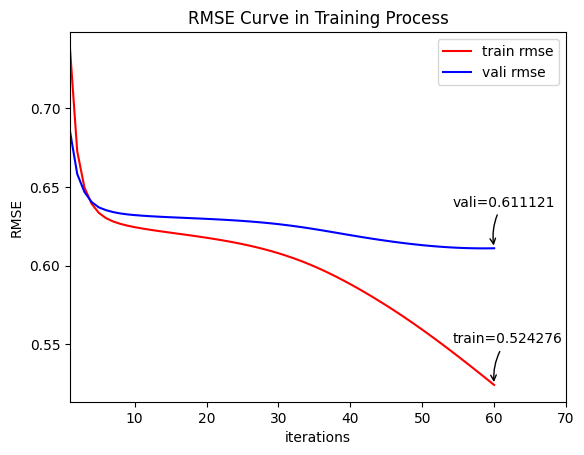

In [6]:
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color='r', label='train rmse')
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color='b', label='vali rmse')
plt.legend()
plt.annotate(r'train=%f' % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.annotate(r'vali=%f' % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords='data', xytext=(-30, 30), textcoords='offset points', fontsize=10,
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=.2'))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.title('RMSE Curve in Training Process')
plt.show()

# Save model
path_to_trained_pmf = 'dataset/data_runs/ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_cuda_{:}_trained_pmf.pt'.format(train_ratio, batch_size, len(train_rmse_list), weight_decay, lr, enable_cuda)
torch.save(model.state_dict(), path_to_trained_pmf)